# Conversational Threads

Many LLM applications have a chatbot-like interface in which the user and the LLM application engage in a multi-turn conversation. In order to track these conversations, you can use the Threads feature in LangSmith.

This is relevant to our RAG application, which should maintain context from prior conversations with users.

### Setup

In [33]:
# Or you can use a .env file
from dotenv import load_dotenv
load_dotenv(dotenv_path="../../.env", override=True)

True

### Group traces into threads


A Thread is a sequence of traces representing a single conversation. Each response is represented as its own trace, but these traces are linked together by being part of the same thread.

To associate traces together, you need to pass in a special metadata key where the value is the unique identifier for that thread.

The key value is the unique identifier for that conversation. The key name should be one of:

- session_id
- thread_id
- conversation_id.

The value should be a UUID.

In [34]:
import uuid
thread_id = uuid.uuid4()

In [35]:
from langsmith import traceable
from openai import OpenAI
from typing import List
import nest_asyncio
from utils import get_vector_db_retriever

openai_client = OpenAI()
nest_asyncio.apply()
retriever = get_vector_db_retriever()

@traceable(run_type="chain")
def retrieve_documents(question: str):
    return retriever.invoke(question)

@traceable(run_type="chain")
def generate_response(question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    rag_system_prompt = """You are an assistant for question-answering tasks. 
    Use the following pieces of retrieved context to answer the latest question in the conversation. 
    If you don't know the answer, just say that you don't know. 
    Use three sentences maximum and keep the answer concise.
    """
    messages = [
        {
            "role": "system",
            "content": rag_system_prompt
        },
        {
            "role": "user",
            "content": f"Context: {formatted_docs} \n\n Question: {question}"
        }
    ]
    return call_openai(messages)

@traceable(run_type="llm")
def call_openai(
    messages: List[dict], model: str = "gpt-4o-mini", temperature: float = 0.0
) -> str:
    return openai_client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
    )

@traceable(run_type="chain")
def langsmith_rag(question: str):
    documents = retrieve_documents(question)
    response = generate_response(question, documents)
    return response.choices[0].message.content


### Now let's run our application twice with this thread_id

In [36]:
question = "How do I add metadata to a Trace?"
ai_answer = langsmith_rag(question, langsmith_extra={"metadata": {"thread_id": thread_id}})
print(ai_answer)

To add metadata to a trace in LangSmith, you can use a dictionary of key-value pairs when creating or updating the trace. This metadata can include information such as the environment, user details, or internal correlation IDs. Ensure that the same metadata is also attached to the corresponding run for better tracking and analysis.


In [37]:
question = "How can I add tags to a Trace?"
ai_answer = langsmith_rag(question, langsmith_extra={"metadata": {"thread_id": thread_id}})
print(ai_answer)

You can add tags to a trace in LangSmith by sending arbitrary strings that categorize or label the trace. Tags can be included as part of the metadata when you create or update a trace. For more detailed instructions, refer to the documentation on adding metadata and tags to traces.


### My Understanding :  We have formed a thread, which makes up a chat interface, where users can ask questions and there will be a back and forth.each input from the user forms a new trace and all these traces are bundled up together in a thread which gives us that chat interface type of look.
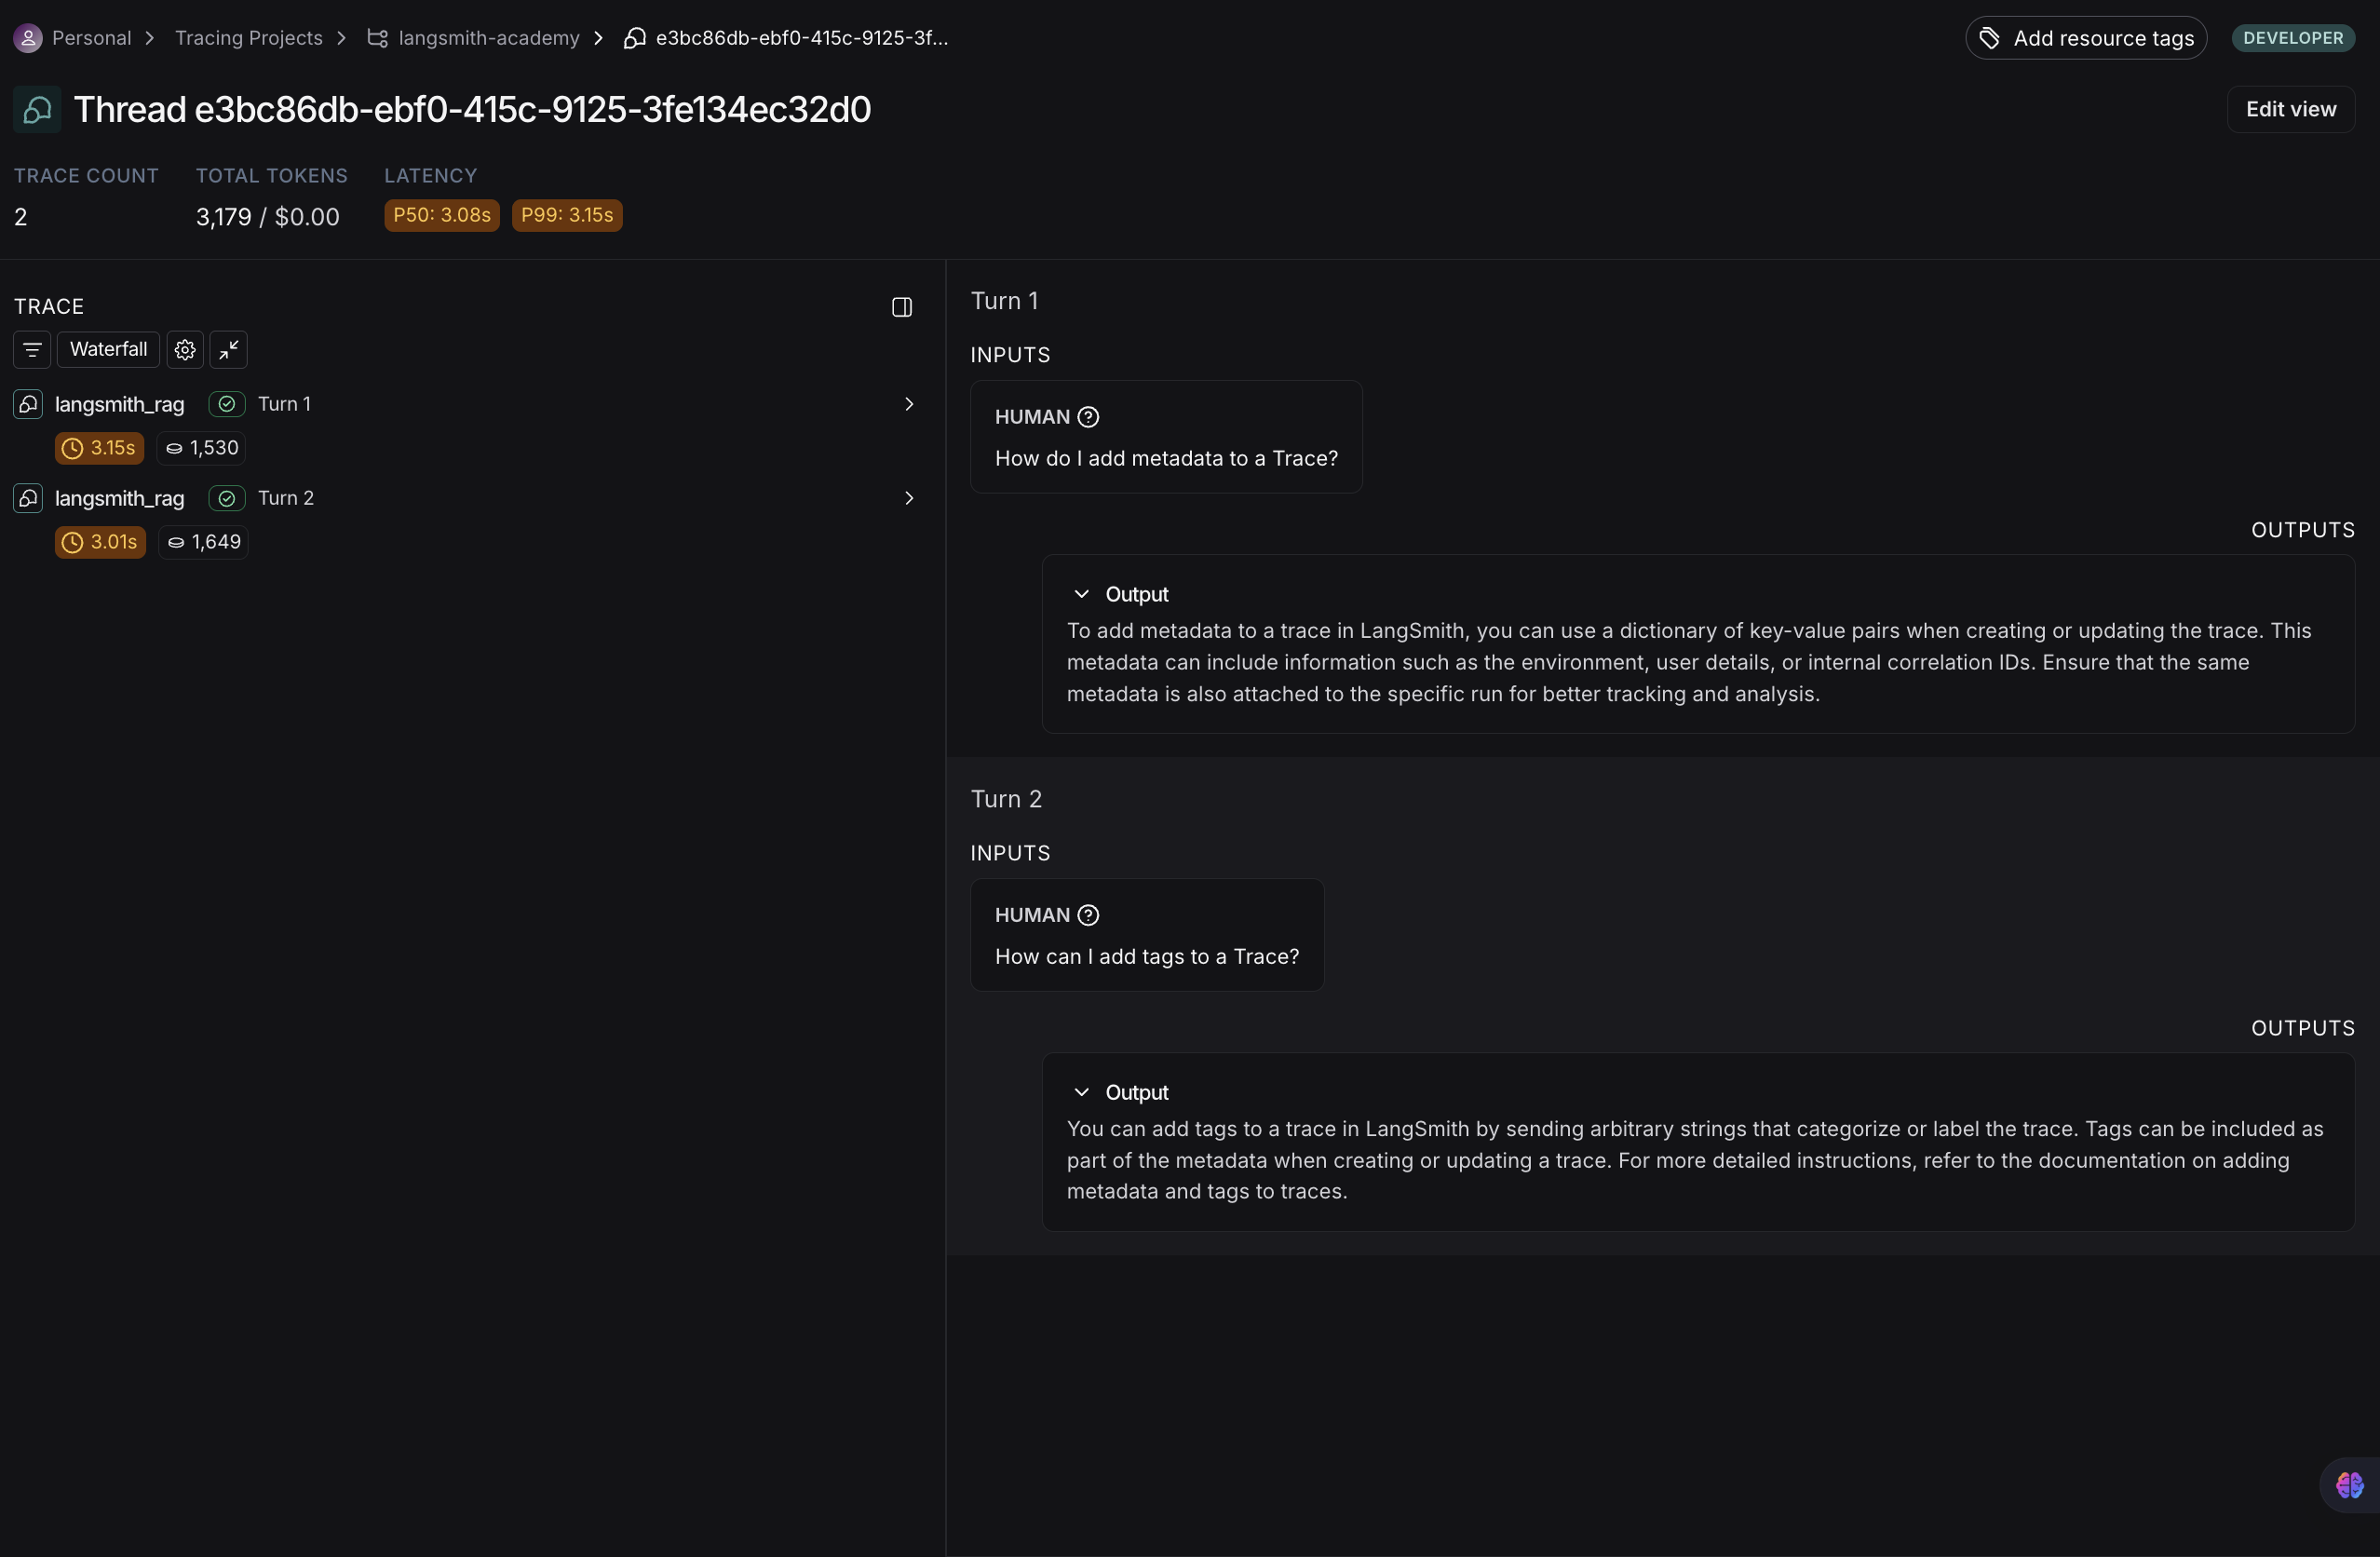

## my own part:

In [38]:
threadd_id = uuid.uuid4()
question = "What is Langchain and Langsmith"
ai_answer = langsmith_rag(question, langsmith_extra={"metadata": {"thread_id": threadd_id}})
print(ai_answer)

LangChain is a framework designed for building applications that utilize large language models (LLMs), providing tools for retrieval, agents, and evaluation. LangSmith, on the other hand, is a platform for LLM observability and evaluation, allowing users to monitor and assess their applications' performance. Both tools can be used independently or together to enhance the development and deployment of AI applications.


In [39]:
question = "how does langhchain help us ?"
ai_answer = langsmith_rag(question, langsmith_extra={"metadata": {"thread_id": threadd_id}})
print(ai_answer)

LangChain provides tools for LLM observability and evaluation, enabling users to monitor and assess the performance of their language models. It offers a scalable cloud architecture, allowing for efficient management of production workloads. Additionally, LangChain supports various features like prompt engineering and self-hosting options to enhance user experience.


In [40]:
question = "List everything that Langsmith can do, in a bulleted form "
ai_answer = langsmith_rag(question, langsmith_extra={"metadata": {"thread_id": threadd_id}})
print(ai_answer)

- Run multiple experiments on a given dataset
- Test different configurations of applications (e.g., prompts or LLMs)
- View all experiments associated with a dataset
- Compare multiple experiments in a comparison view


In [41]:
question = "Now list 8 things langchain can do in a bulleted list "
ai_answer = langsmith_rag(question, langsmith_extra={"metadata": {"thread_id": threadd_id}})
print(ai_answer)

- 1-Click Deploy for easy service deployment.
- Horizontally-scalable service for production-sized deployments.
- Assistants API with 30+ API endpoints including state and memory.
- Cron scheduling for automated tasks.
- Authentication and authorization for LangGraph APIs.
- Support for Cloud, Hybrid, or Self-Hosted deployment types.
- Role-Based Access Control with organization roles (User and Admin).
- Community support via Slack and email, along with team training and architectural guidance.


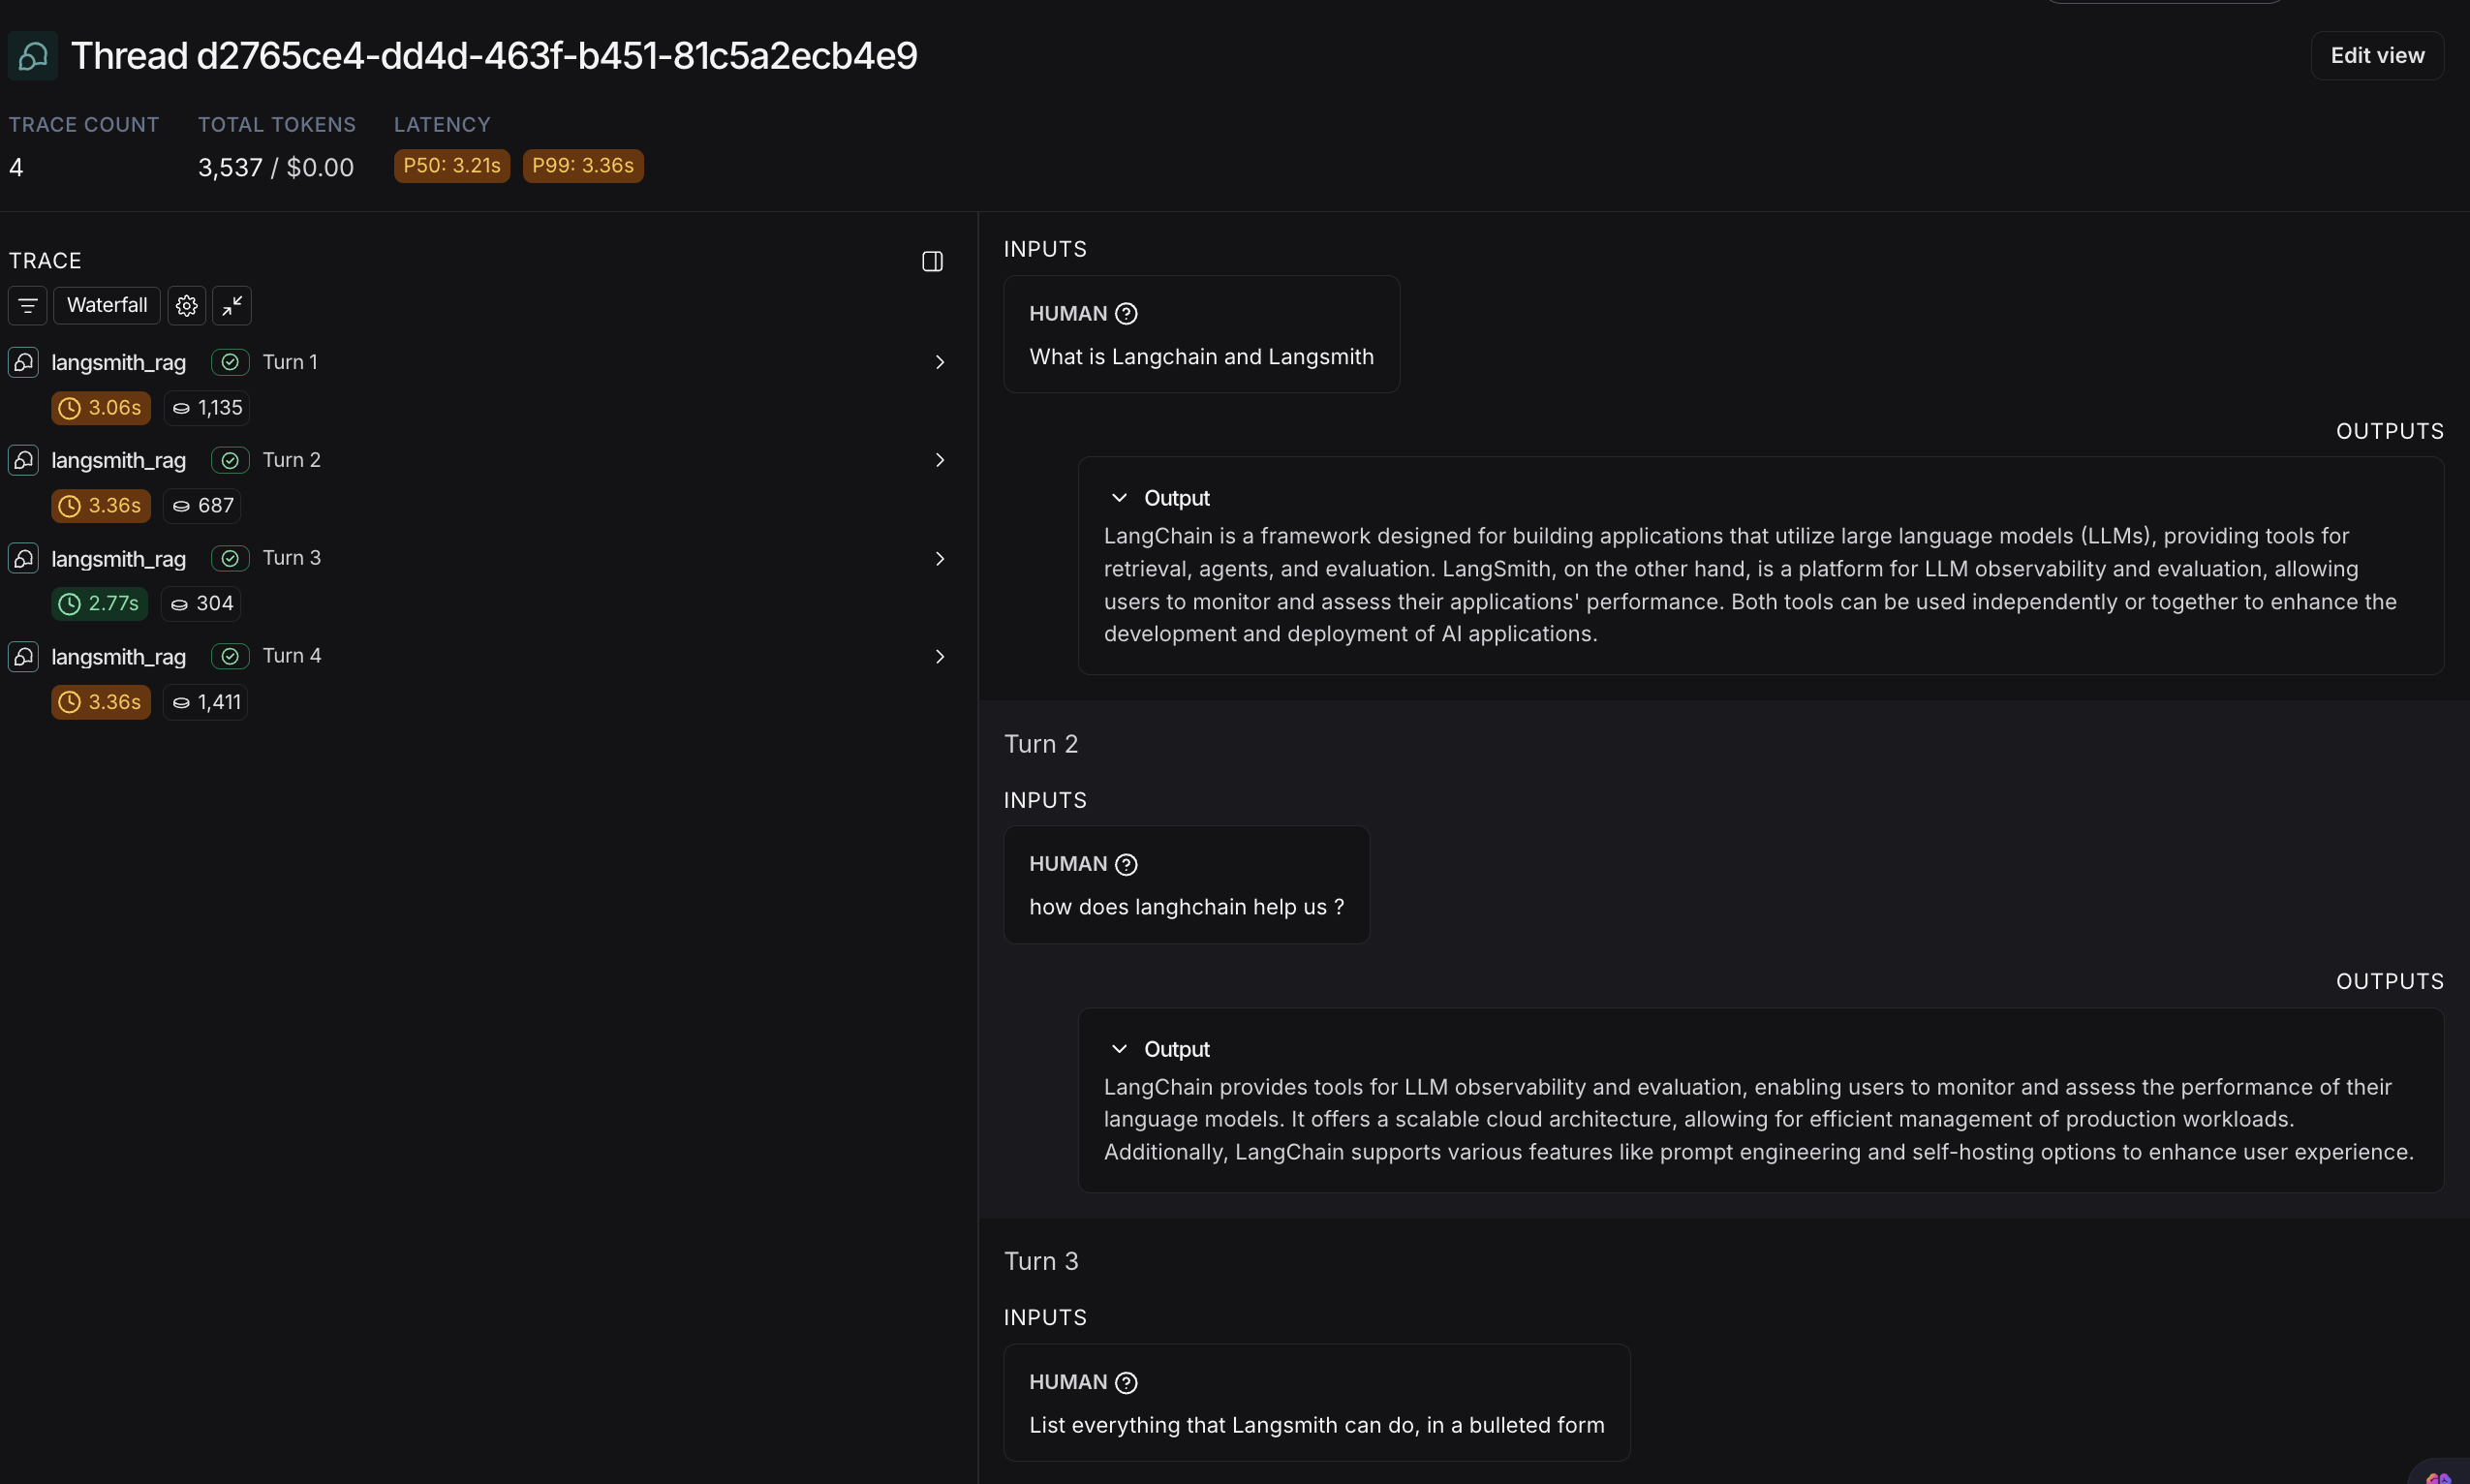



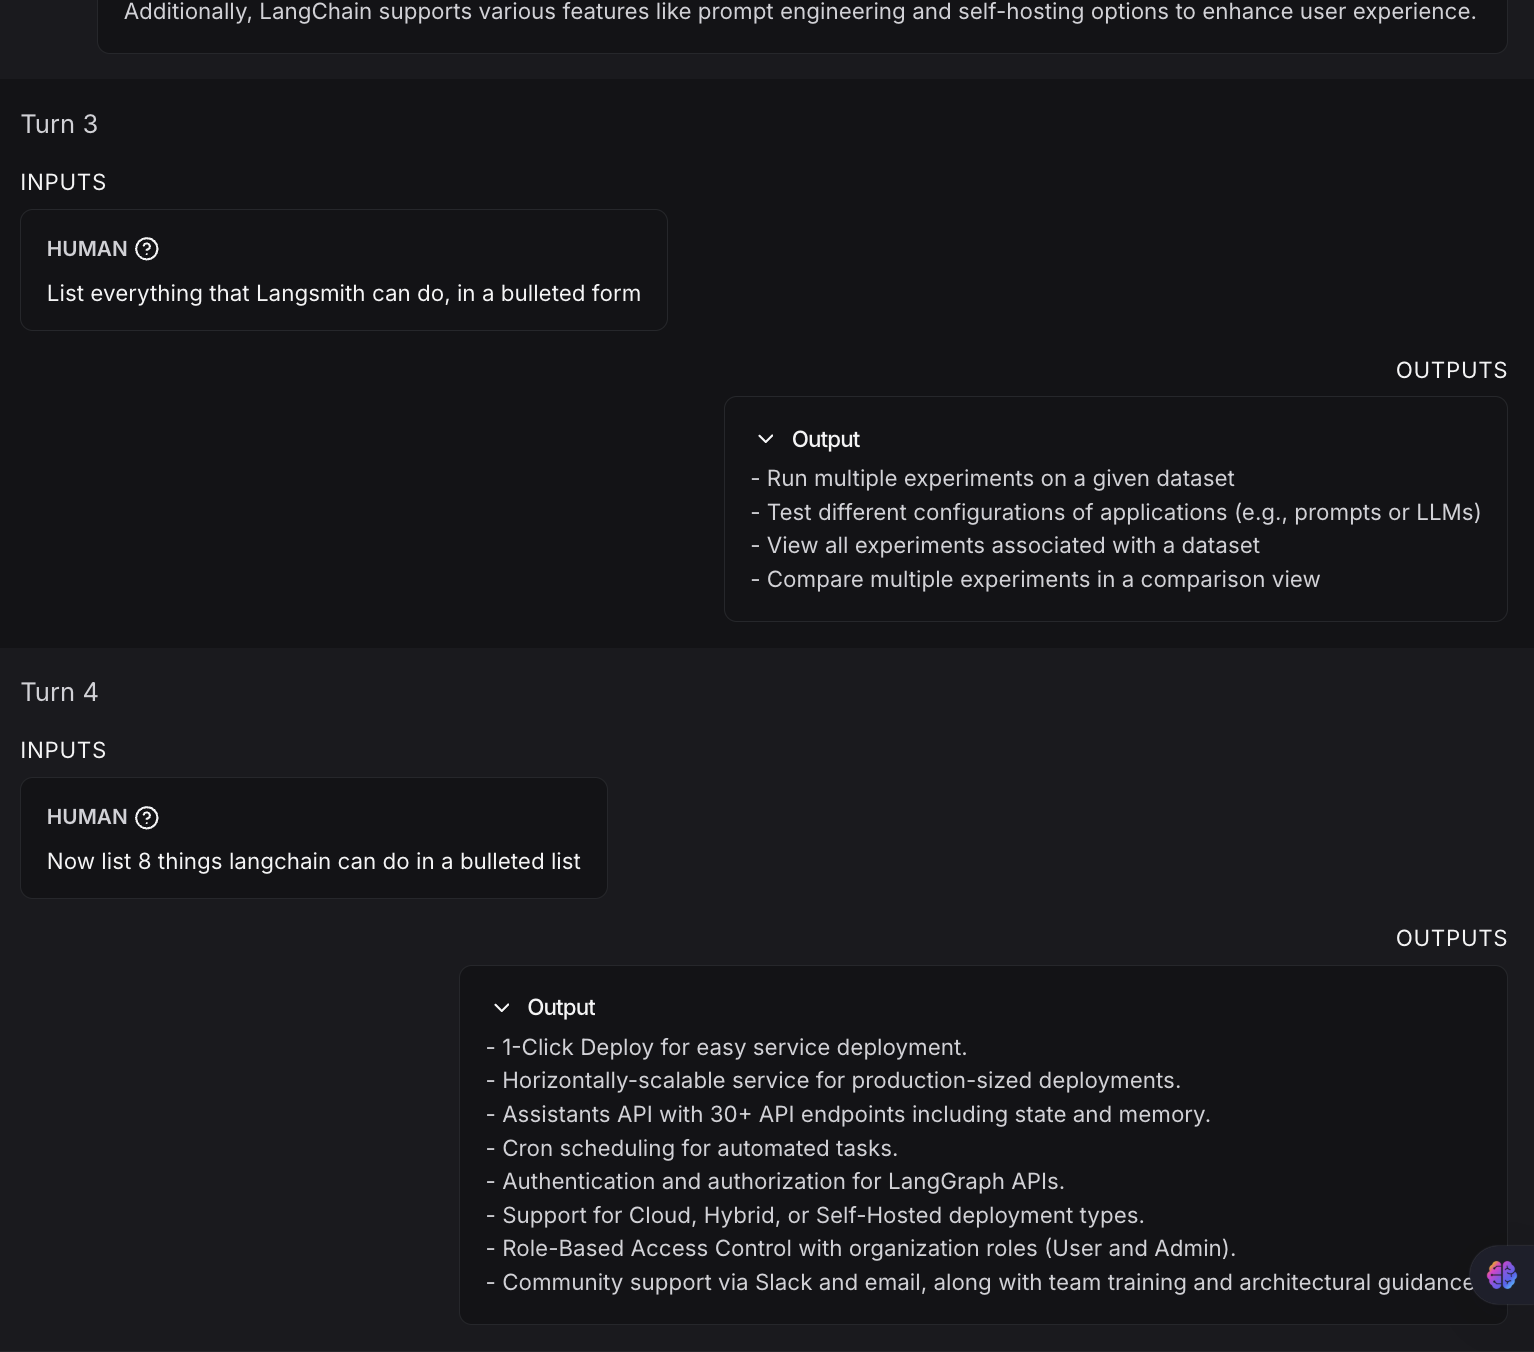